# Классификация комментариев в интернет-магазине.

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

**Задача:** Необходимо обучить модель классифицировать комментарии на позитивные и негативные.

**Описание данных:** Тексты комментариев с разметкой о токсичности.

## Подготовка данных.

### Ознакомление с данными.

#### Импортируем необходимые для работы библиотеки.

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline

#### Ознакамливаемся с файлом с разметками фильмов.

##### Открываем файл с разметкой фильмов и сохраняем в переменной.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving toxic_comments.csv to toxic_comments.csv


In [3]:
data = pd.read_csv("toxic_comments.csv", index_col=0)

##### Выводим первые 5 строк файла.

In [4]:
data.sample(5)

,text,toxic
106920,Re the Golden Jubilee Medal. Depending upon th...,0
37077,leave da message for da klarky kat,0
16995,I think Masem (whom I respect very highly) sum...,0
96779,I know the going ons between this group of Ind...,0
15273,"""\nI don't know, but I hope the USA puts the C...",0


#####  Выводим основную информацию датасета с разметкой фильмов методом info().

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


#####  Проверяем сбалансированность классов.

In [6]:
# Подсчет количества значений в целевой переменной
class_counts = data['toxic'].value_counts()

print(class_counts)

0    143106
1     16186
Name: toxic, dtype: int64


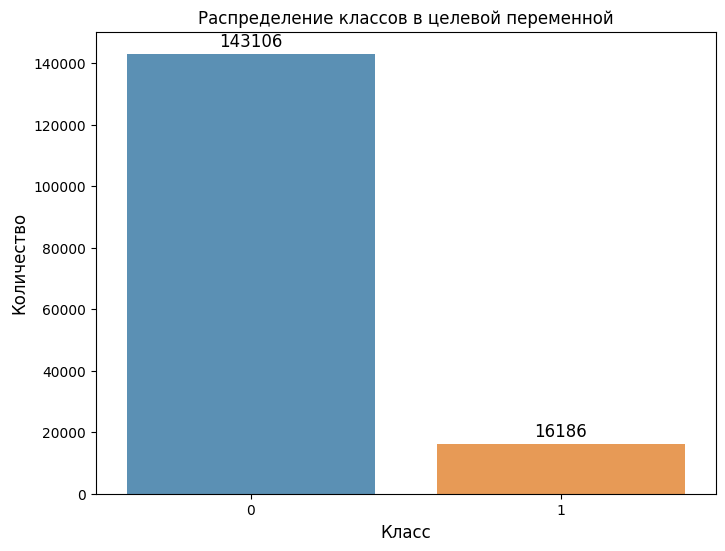

In [7]:
# Визуализация
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, alpha=0.8)
plt.title('Распределение классов в целевой переменной')
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Класс', fontsize=12)

# Добавление количества над столбцами
for p, label in zip(ax.patches, class_counts.values):
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center',
                 xytext = (0, 9),
                 textcoords = 'offset points', fontsize=12)

plt.show()

Датасет несбалансированный: количество негативных комментариев почти в 10 раз меньше, чем количество положительных

### Предобработка данных.

#### Очищаем текст от лишних символов.

In [8]:
%%time
SPACES = r'([ ])\1+'
DOTS = r'[.]+'
SINGLE_WORD_IN_BRACKETS = r'\(.*?\)'
SPECIAL_CHARACTERS_IN_WORDS = r'\S*[:#]\S*'
IP_ADDRESSES = r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'
DATE_TIME = r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2}\b'
SINGLE_WORD_IN_BRACKETS = r'\(\w+\)'
UTC = r'\bUTC\b'
COMMA_BETWEEN_SPACES = r'\s,\s'
LETTERS = r'[^a-zA-Z\' ]'

def clean_text(text):
    txt = re.sub(IP_ADDRESSES, ' ', text)
    txt = re.sub(SINGLE_WORD_IN_BRACKETS, ' ', txt)
    txt = re.sub(DATE_TIME, ' ', txt)
    txt = re.sub(SPECIAL_CHARACTERS_IN_WORDS, ' ', txt)
    txt = re.sub(LETTERS, ' ', txt)
    txt = re.sub(UTC, ' ', txt)
    txt = re.sub(COMMA_BETWEEN_SPACES, ' ', txt)
    txt = re.sub(SPACES, ' ', txt)
    txt = re.sub(DOTS, '.', txt)
    txt = txt.encode('ascii', 'ignore').decode()
    txt = txt.strip()
    return txt.lower()

# применяем tqdm
tqdm.pandas()

data['cleaned_text'] = data['text'].progress_apply(clean_text)

100%|██████████| 159292/159292 [00:22<00:00, 7138.02it/s]

CPU times: user 22 s, sys: 54.2 ms, total: 22.1 s
Wall time: 22.3 s


Проверяем получившийся результат.

In [9]:
print(data['text'][0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [10]:
print(data['cleaned_text'][0])

explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now


#### Осуществляем лемматизацию и дальнейшую очистку текста от стоп-слов и имён. Готовим текст к векторизации.

In [11]:
%%time

# Загрузка стоп-слов и списка имен
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('names', quiet=True)

CPU times: user 267 ms, sys: 46.7 ms, total: 313 ms
Wall time: 481 ms


True

In [12]:
from nltk.corpus import names

In [13]:
%%time
# Загрузка модели языка для SpaCy
spacy_model = "en_core_web_sm"
nlp = spacy.load(spacy_model)

CPU times: user 1.03 s, sys: 34.9 ms, total: 1.07 s
Wall time: 1.19 s


In [14]:
%%time

# Объединяем список имен мужчин и женщин и приводим их к нижнему регистру
name_list = [name.lower() for name in names.words('male.txt') + names.words('female.txt')]

nlp = spacy.load('en_core_web_sm')
def clean_texts(texts):
    cleaned_texts = []
    for doc in tqdm(nlp.pipe(texts, n_process=-1)):
        txt = [token.lemma_ for token in doc if not token.is_stop and token.lemma_ not in name_list]
        cleaned_text = ' '.join(txt)
        cleaned_texts.append(re.sub(SPACES, r'\1', cleaned_text))
    return cleaned_texts

data['clean_text'] = clean_texts(data['cleaned_text'])

159292it [30:56, 85.79it/s] 

CPU times: user 19min 52s, sys: 8.89 s, total: 20min 1s
Wall time: 30min 57s


In [15]:
print(data['cleaned_text'][0])

explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now


In [16]:
print(data['clean_text'][0])

explanation edit username hardcore metallica revert vandalism closure gas vote new york dolls fac remove template talk retire


In [17]:
print(data['cleaned_text'][1])

d'aww he matches this background colour i'm seemingly stuck with thanks


In [18]:
print(data['clean_text'][1])

d'aww match background colour seemingly stuck thank


In [19]:
data.head()

,text,toxic,cleaned_text,clean_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation edit username hardcore metallica r...
1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour i'm se...,d'aww match background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not trying to edit war it's...,hey man try edit war constantly remove relevan...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...,real suggestion improvement wonder section sta...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,sir hero remember


#### Создадим и визуализируем облако слов.

In [20]:
%%time
# Подготовка данных
toxic_comments = data[data['toxic'] == 1]
non_toxic_comments = data[data['toxic'] == 0]

# Соединяем все комменты в один текст
toxic_text = ' '.join(toxic_comments['clean_text'])
non_toxic_text = ' '.join(non_toxic_comments['clean_text'])

CPU times: user 79 ms, sys: 21.9 ms, total: 101 ms
Wall time: 101 ms


In [21]:
%%time
# Создаем облака слов
toxic_wordcloud = WordCloud(width=800, height=400, background_color ='white', collocations=False).generate(toxic_text)
non_toxic_wordcloud = WordCloud(width=800, height=400, background_color ='white', collocations=False).generate(non_toxic_text)

CPU times: user 7.24 s, sys: 230 ms, total: 7.47 s
Wall time: 7.52 s


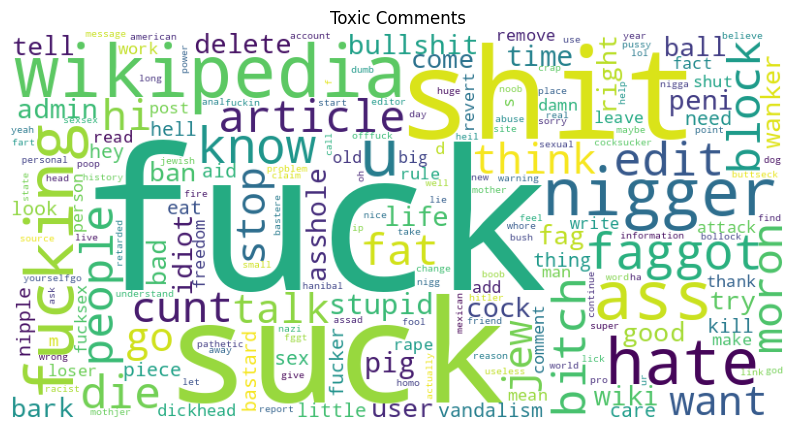

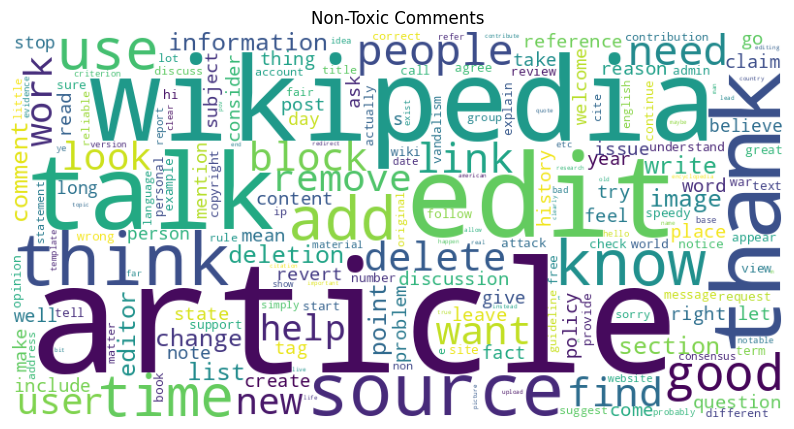

CPU times: user 680 ms, sys: 246 ms, total: 926 ms
Wall time: 689 ms


In [22]:
%%time
# Отображаем облака слов
plt.figure(figsize=(10, 7))
plt.imshow(toxic_wordcloud)
plt.axis('off')
plt.title('Toxic Comments')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(non_toxic_wordcloud)
plt.axis('off')
plt.title('Non-Toxic Comments')
plt.show()

#### Удаляем лишние столбцы.

In [23]:
data = data.drop(columns=['text', 'cleaned_text'])
data.head()

,toxic,clean_text
0,0,explanation edit username hardcore metallica r...
1,0,d'aww match background colour seemingly stuck ...
2,0,hey man try edit war constantly remove relevan...
3,0,real suggestion improvement wonder section sta...
4,0,sir hero remember


#### Разбиваем данные на обучающую и тестовую выборки.

In [24]:
X = data['clean_text']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Создаем и обучаем модели. Оцениваем их метрики на кросс-валидации.

### Создаем и обучаем модель логистической регрессии. Оцениваем ее метрики на кросс-валидации.

In [25]:
%%time
# Параметры для grid search
params = {
    'model__C': [0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2']
}

# Создаем pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40, ngram_range=(1, 4))),
    ('tfidf', TfidfTransformer()),
    ('model', LogisticRegression(max_iter=10000, random_state=42, solver = 'liblinear'))
])

# Создаем объект grid search
lr_grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='f1')

# Обучаем модель
lr_grid.fit(X_train, y_train)

# Печатаем наилучшие параметры и оценку
print("Best parameters:", lr_grid.best_params_)
print("Best F1 score:", lr_grid.best_score_)

Best parameters: {'model__C': 1, 'model__penalty': 'l1'}
Best F1 score: 0.7630538535646944
CPU times: user 27.1 s, sys: 4.23 s, total: 31.3 s
Wall time: 12min 7s


### Создаем и обучаем модель пассивно-агрессивного классификатора. Оцениваем ее метрики на кросс-валидации.

In [26]:
%%time
# Параметры для grid search
params = {
    'model__C': [0.1, 1, 10, 100],
}

# Создаем pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40, ngram_range=(1, 4))),
    ('tfidf', TfidfTransformer()),
    ('model', PassiveAggressiveClassifier(max_iter=1000, random_state=42))
])

# Создаем объект grid search
pac_grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='f1')

# Обучаем модель
pac_grid.fit(X_train, y_train)

# Печатаем наилучшие параметры и оценку
print("Best parameters:", pac_grid.best_params_)
print("Best F1 score:", pac_grid.best_score_)

Best parameters: {'model__C': 0.1}
Best F1 score: 0.7650510661721319
CPU times: user 24.4 s, sys: 2.79 s, total: 27.2 s
Wall time: 5min 47s


### Создаем и обучаем модель LightGBM. Оцениваем ее метрики на кросс-валидации.

In [27]:
%%time

# Параметры для grid search
params = {
    'model__num_leaves': [31, 127],
    'model__min_data_in_leaf': [50, 100]
}

# Создаем pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.85, min_df=3, ngram_range=(1, 2))),
    ('model', lgb.LGBMClassifier(verbose=-1, seed=42))
])

# Создаем объект grid search
lgb_grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='f1', verbose=-1)

# Обучаем модель
lgb_grid.fit(X_train, y_train)

# Печатаем наилучшие параметры и оценку
print("Best parameters:", lgb_grid.best_params_)
print("Best F1 score:", lgb_grid.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'model__min_data_in_leaf': 50, 'model__num_leaves': 127}
Best F1 score: 0.7598747845324664
CPU times: user 2min 20s, sys: 3.59 s, total: 2min 24s
Wall time: 20min 55s


### Подбираем оптимальный порог классификации для наилучшей модели.

In [28]:
%%time
# функция для преобразования вероятностей в метки
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# преобразование оценок в вероятности с помощью сигмоидной функции
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Разделим исходные тренировочные данные на новые тренировочные и валидационные наборы
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Обучим модель на новом тренировочном наборе
pac_grid.fit(X_train_new, y_train_new)

# Получите лучший порог на валидационном наборе
yhat = pac_grid.decision_function(X_val)
probs = sigmoid(yhat)
thresholds = np.arange(0, 1, 0.001)
scores = [f1_score(y_val, to_labels(probs, t)) for t in thresholds]
ix = np.argmax(scores)
optimal_threshold = thresholds[ix]

print('Оптимальный порог: %.3f, Лучшая метрика F1: %.5f' % (optimal_threshold, scores[ix]))

# Сохраните модель с лучшими гиперпараметрами и порогом в переменной
best_model = pac_grid.best_estimator_
# Здесь мы не можем установить порог напрямую в модели, поэтому его нужно будет применять вручную при получении прогнозов

Оптимальный порог: 0.414, Лучшая метрика F1: 0.78228
CPU times: user 31.3 s, sys: 1.61 s, total: 32.9 s
Wall time: 4min 38s


**Выводы:**
- Все модели позволили достичь целевого значения метрики.
- Наилучший результат показала модель пассивно-агрессивного классификатора.

## Оценим качество наилучшей модели на тестовой выборке.

### Оценим качество наилучшей модели на тестовой выборке.

In [29]:
%%time

# Получаем оценки для тестовых данных
yhat = best_model.decision_function(X_test)
# Преобразовать оценки в вероятности
probs = sigmoid(yhat)
# Преобразовать вероятности в метки, используя оптимальный порог
y_pred = to_labels(probs, optimal_threshold)

# Вычисляем F1-оценку
f1 = f1_score(y_test, y_pred)

print("Метрика F1 на тестовой выборке:", f1)

Метрика F1 на тестовой выборке: 0.7703435804701628
CPU times: user 3.22 s, sys: 8.76 ms, total: 3.23 s
Wall time: 3.26 s


### Выявляем ключевые слова для классификации наилучшей модели.

In [30]:
# Получаем список слов, используемых в векторизаторе
words = best_model.named_steps['vect'].get_feature_names_out()

In [31]:
# Получаем веса, используемые в модели
weights = best_model.named_steps['model'].coef_[0]

In [32]:
# Создаем DataFrame из слов и весов и отсортировываем его по весам
df = pd.DataFrame({'Cлова': words, 'Вес': weights})
df = df.sort_values(by='Вес', ascending=False)

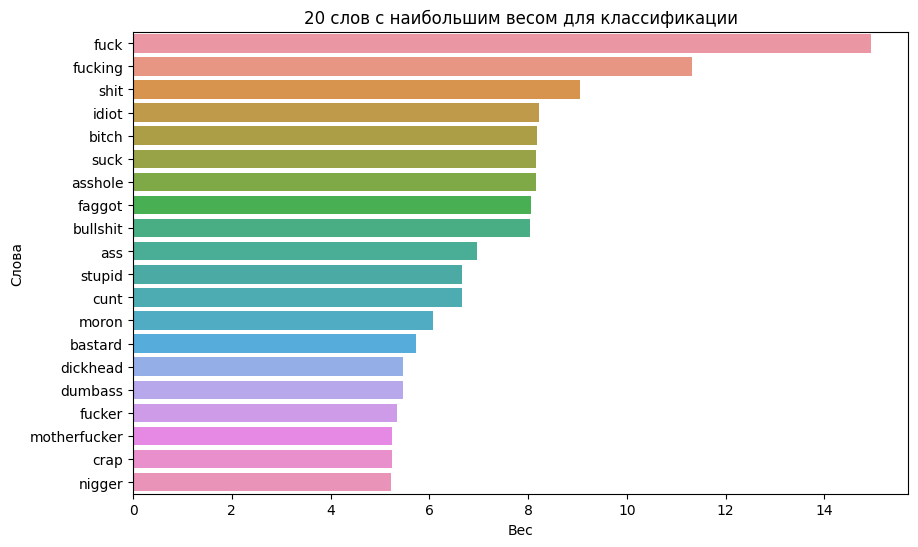

In [33]:
# Визуализируем 20 слов с наибольшим весом
plt.figure(figsize=(10, 6))
sns.barplot(x='Вес', y='Cлова', data=df.head(20))
plt.title('20 слов с наибольшим весом для классификации')
plt.show()

## Вывод.

Для проекта был представлен датасет, состоящий из почти 160 тысяч строк и двух столбцов: с текстами комментариев и разметкой об их токсичности. При этом датасет был несбалансирован: токсичных комментариев было почти в 10 раз меньше, чем не токсичных.
После ознакомления с данными была осуществлена предобработка, состоящая из следующих этапов:
- Очистка текста от лишних символов при помощи регулярных выражений.
- Лемматизация текста при помощи библиотеки SpaCy c пайплайном и удалением стоп-слов и имен с использованием библиотеки nltk.

После очистки текста была построена диаграмма облака слов для каждого из классов комментариев.
Далее при помощи GridsearchCV и встроенных в него пайплайнов были обучены три модели с перебором оптимальных гиперпараметров для них: логистическая регрессия, пассивно-агрессивный классификатор и LightGBM. Каждая модель с оптимальными гиперпараметрами позволила достичь целевого показателя F1-метрики. При этом добавление параметра взвешивания классов привело к существенному снижению метрики F1. Чуть лучше других моделей себя проявил пассивно-агрессивный классификатор. С помощью тюнинга порога классификации удалось еще немного улучшить метрику F1 наилучшей модели.

Она подтвердила свою эффективность на тестовых данных.

Далее были выявлены и визуализированы 20 слов с наибольшим весом для классификации комментариев как токсичных. Ими ожидаемо оказались матерные ругательства:)